In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from spacetime.spacetime import SpaceTime, Data
from spacetime.simulate import Simulator

from spacetime.models import LinearBlock#, AutoEncoder
from spacetime.trainers import Trainer, Validator
from spacetime.losses import OptimAction, LagrangianLoss
from spacetime.losses import KineticLoss, InteractionLoss
from spacetime.losses import Coefficients, Control
from spacetime.utils import rand_norm, ortho_norm
from spacetime.utils import check_nan, Logger
from spacetime.sampler import NodeData, GraphSampler

In [4]:
n_nodes=20
node_list = list(range(n_nodes))
node_dict = {0:node_list}

graph_params = {'degree':6, 'graph_type':'erdos-renyi', 'w_range':(0.5, 2.0), 
                'force_positive':False, 'seed':101}
data_params = {'n_samples':7500, 'linear_type':'nonlinear_2', 'sem_type':'linear-gauss', 
               'noise_scale':1.0, 'x_dims':5, 'seed':0}

simulating a random 6-degree erdos-renyi dag with range (0.5, 2.0) (seed 101)
simulating 7500 samples from a linear-gauss sem with nonlinear_2 causal effects


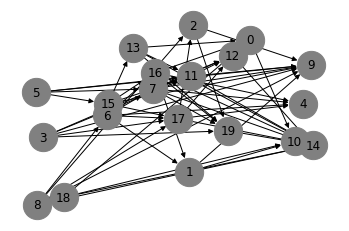

In [5]:
g_true = SpaceTime(Simulator.random(n_nodes, **graph_params))
data = Data(Simulator.sem(g_true.adj.numpy(), **data_params))

g_true.draw_graph()

In [6]:
col_plot_dict = {0:(4,2), 1:(4,1), 2:(2,1), 3:(3,0)}
mutilate = 1
observe = 2
latent = 0

In [7]:
####################################################################
### Ripped heavily from https://github.com/fishmoon1234/DAG-GNN
####################################################################
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalBlock(nn.Module):
    """SEM operator module."""
    def __init__(self, n_nodes, d_causal, vectorize=False, boost=False):
        super(CausalBlock, self).__init__()
        self.n_nodes = n_nodes
        self.adj = nn.Parameter(rand_norm(0, 1e-9, n_nodes, n_nodes).double(), requires_grad=True)
        
        norm_1, norm_2 = ortho_norm(1e-7, n_nodes, d_causal)
        self.q = nn.Parameter(norm_1.double(), requires_grad=True)
        self.k = nn.Parameter(norm_2.double(), requires_grad=True)
        
        self.vectorize = vectorize        
        self.boost = boost
    
    def forward(self, x):
        x = self.bmm(self.op().fill_diagonal_(0.0), x)
        return x
    
    def enc_sem(self, x):
        z = self.bmm(self.sem(), x)
        return z
    
    def dec_sem(self, x):
        x = self.bmm(self.sem().inverse(), x)
        return x
        
    def bmm(self, m, x):
        return torch.einsum('ij,ajc->aic', m, x)

    def op(self):
        return self.adj_p().transpose(-2,-1)
    
    def sem(self):
        return torch.eye(self.n_nodes).double()-(self.op().fill_diagonal_(0.0))
    
    def adj_p(self):
        if self.vectorize:
            return self.adj_vec()
        else:
            return self.adj_mat()
            
    def adj_vec(self):
        check_nan({'q':self.q, 'k':self.k})
        if self.boost:
            return torch.sinh(3*torch.matmul(self.q, self.k.transpose(-2,-1)))
        else:
            return torch.matmul(self.q, self.k.transpose(-2,-1))
        
    def adj_mat(self):
        check_nan({'adj':self.adj})
        if self.boost:
            return torch.sinh(3*torch.matmul(torch.eye(self.n_nodes).double(), self.adj))
        else:
            return torch.matmul(torch.eye(self.n_nodes).double(), self.adj)
        
class AutoEncoder(nn.Module):
    def __init__(self, n_nodes, d_causal, d_x, d_hid, d_z):
        super(AutoEncoder, self).__init__()
        self.embedder = LinearBlock(d_x, d_hid, d_z).double()
        self.debedder = LinearBlock(d_z, d_hid, d_x).double()
        self.causal = CausalBlock(n_nodes, d_causal, vectorize=False, boost=False).double()
            
    def encode(self, x):
        x = self.embedder(x)
        return x
    
    def decode(self, z):
        z = self.causal(z)
        z = self.debedder(z)
        return z

    def forward(self, x):
        z = self.encode(x)
        xx = self.decode(z)
        return xx, z, self.causal.adj_p()

In [8]:
model_params = {'n_nodes':n_nodes, 'd_causal':int(2*n_nodes), 
                'd_x':data_params['x_dims'], 'd_hid':64, 'd_z':data_params['x_dims']}

coeff_params = {'l_init':1e-2, 'c_init':1.0, 'tau_init':1e-9, 'tr_init':100.}
ctrl_params = {'gamma':0.25/(1), 'eta':10.0/(1)}
opt_params = {'warmups':0, 'lr_init':3e-3, 'h_tol':1e-9, 'max_iters':40}

train_params = {'batch_size':100, 'epochs':5}

In [9]:
import copy

def run_trials(data, n_trials):
    model_log = Logger('models')
    kinetic_log = Logger(*KineticLoss.params)
    interaction_log = Logger(*InteractionLoss.params)
    param_log = Logger(*Trainer.params)
    eval_log = Logger(*Validator.params)
    
    graphs = list()
    
    kinetic = KineticLoss()
    interaction = InteractionLoss.poly(n_nodes, Coefficients(**coeff_params))
    ctrl = Control(**ctrl_params)
    val = Validator(g_true)
    
    c = copy.deepcopy

    for n in range(n_trials):
        model = AutoEncoder(**model_params)
        loss = LagrangianLoss(kinetic=c(kinetic), interaction=c(interaction), 
                              ctrl=c(ctrl), opt=OptimAction(model, **opt_params))

        trainer = Trainer(model, loss, data, **train_params, val=c(val))
        trainer.train()
        
        model_log.append({'models':trainer.model})
        kinetic_log.append(trainer.kinetic_log.full())
        interaction_log.append(trainer.interaction_log.full())
        param_log.append(trainer.param_log.full())
        eval_log.append(trainer.val.log.full())
        
        graphs.append(trainer.loss.interaction.adj)
        
    return model_log, kinetic_log, interaction_log, param_log, eval_log, graphs

In [10]:
model_log, kinetic_log, interaction_log, param_log, eval_log, graphs = run_trials(data, 3)

***Iteration: 0, Best Epoch: 4/5 || elbo: 10^2.959 || kl: 10^2.493 || nll: 10^2.777
     h: 10^-1.387 || l1: 10^1.465 || l: 10^-2.00 || c: 10^0.00 || lr: 10^-2.523
     shd: 56.000 || tpr: 0.500 || fpr: 0.209 || err: 11.965
***Iteration: 1, Best Epoch: 4/5 || elbo: 10^2.684 || kl: 10^2.206 || nll: 10^2.508
     h: 10^-1.026 || l1: 10^1.530 || l: 10^-1.29 || c: 10^0.00 || lr: 10^-2.523
     shd: 56.000 || tpr: 0.500 || fpr: 0.209 || err: 12.413
***Iteration: 2, Best Epoch: 4/5 || elbo: 10^2.562 || kl: 10^2.055 || nll: 10^2.400
     h: 10^-0.878 || l1: 10^1.557 || l: 10^-1.29 || c: 10^1.00 || lr: 10^-2.523
     shd: 51.000 || tpr: 0.536 || fpr: 0.194 || err: 12.651
***Iteration: 3, Best Epoch: 4/5 || elbo: 10^2.461 || kl: 10^1.955 || nll: 10^2.298
     h: 10^-0.837 || l1: 10^1.568 || l: 10^-1.29 || c: 10^2.00 || lr: 10^-2.824
     shd: 48.000 || tpr: 0.571 || fpr: 0.179 || err: 12.759
***Iteration: 4, Best Epoch: 4/5 || elbo: 10^2.430 || kl: 10^1.898 || nll: 10^2.279
     h: 10^-0.948 ||

***Iteration: 8, Best Epoch: 4/5 || elbo: 10^2.495 || kl: 10^1.895 || nll: 10^2.369
     h: 10^-2.493 || l1: 10^1.516 || l: 10^3.76 || c: 10^6.00 || lr: 10^-3.368
     shd: 40.000 || tpr: 0.643 || fpr: 0.149 || err: 13.061
***Iteration: 9, Best Epoch: 4/5 || elbo: 10^2.506 || kl: 10^1.882 || nll: 10^2.389
     h: 10^-2.874 || l1: 10^1.520 || l: 10^3.76 || c: 10^7.00 || lr: 10^-3.368
     shd: 36.000 || tpr: 0.679 || fpr: 0.134 || err: 13.239
***Iteration: 10, Best Epoch: 4/5 || elbo: 10^2.503 || kl: 10^1.862 || nll: 10^2.390
     h: 10^-3.085 || l1: 10^1.524 || l: 10^4.28 || c: 10^7.00 || lr: 10^-3.426
     shd: 36.000 || tpr: 0.679 || fpr: 0.134 || err: 13.378
***Iteration: 11, Best Epoch: 4/5 || elbo: 10^2.509 || kl: 10^1.846 || nll: 10^2.403
     h: 10^-3.456 || l1: 10^1.526 || l: 10^4.28 || c: 10^8.00 || lr: 10^-3.426
     shd: 30.000 || tpr: 0.732 || fpr: 0.112 || err: 13.538
***Iteration: 12, Best Epoch: 4/5 || elbo: 10^2.515 || kl: 10^1.833 || nll: 10^2.414
     h: 10^-3.941 || 

***Iteration: 16, Best Epoch: 4/5 || elbo: 10^2.492 || kl: 10^1.719 || nll: 10^2.411
     h: 10^-5.126 || l1: 10^1.535 || l: 10^5.61 || c: 10^11.00 || lr: 10^-3.564
     shd: 16.000 || tpr: 0.857 || fpr: 0.060 || err: 7.563
***Iteration: 17, Best Epoch: 4/5 || elbo: 10^2.493 || kl: 10^1.701 || nll: 10^2.417
     h: 10^-5.629 || l1: 10^1.534 || l: 10^5.61 || c: 10^12.00 || lr: 10^-3.602
     shd: 16.000 || tpr: 0.857 || fpr: 0.060 || err: 7.468
***Iteration: 18, Best Epoch: 4/5 || elbo: 10^2.490 || kl: 10^1.679 || nll: 10^2.417
     h: 10^-5.917 || l1: 10^1.536 || l: 10^6.44 || c: 10^12.00 || lr: 10^-3.637
     shd: 16.000 || tpr: 0.857 || fpr: 0.060 || err: 7.397
***Iteration: 19, Best Epoch: 4/5 || elbo: 10^2.489 || kl: 10^1.657 || nll: 10^2.420
     h: 10^-6.353 || l1: 10^1.538 || l: 10^6.44 || c: 10^13.00 || lr: 10^-3.637
     shd: 16.000 || tpr: 0.857 || fpr: 0.060 || err: 7.327
***Iteration: 20, Best Epoch: 4/5 || elbo: 10^2.485 || kl: 10^1.635 || nll: 10^2.419
     h: 10^-6.627 |

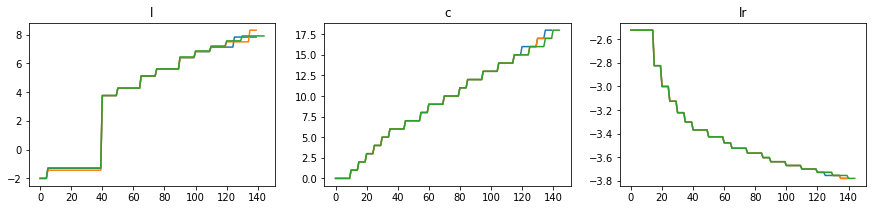

In [11]:
fig, axs = plt.subplots(1,3, figsize=(15, 3))
param_log.plot('l', axs[0])
param_log.plot('c', axs[1])
param_log.plot('lr', axs[2])
plt.show()

# fig, axs = plt.subplots(1,2, figsize=(10, 3))
# interaction_log.plot('h', axs[0])
# interaction_log.plot('l1', axs[1])
# plt.show()

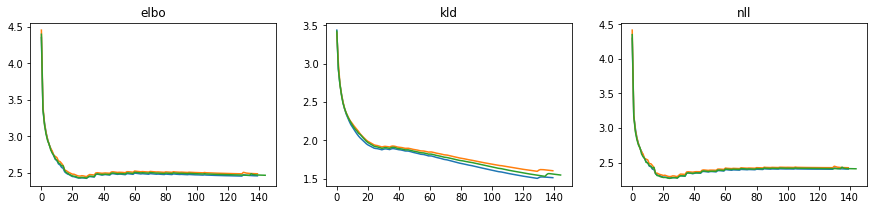

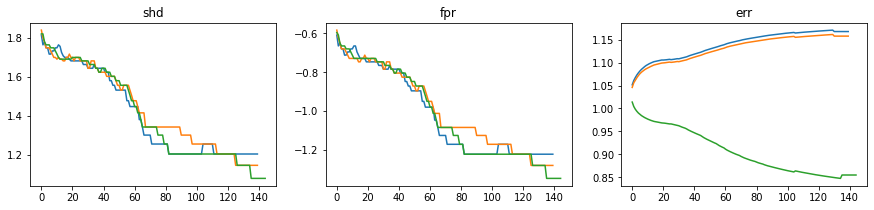

Mean SHD: 14.0000 +- 1.6330
Mean Err: 12.0883 +- 3.4898


In [12]:
fig, axs = plt.subplots(1,3, figsize=(15, 3))
kinetic_log.plot('elbo', axs[0])
kinetic_log.plot('kld', axs[1])
kinetic_log.plot('nll', axs[2])
plt.show()

fig, axs = plt.subplots(1,3, figsize=(15, 3))
eval_log.plot('shd', axs[0])
eval_log.plot('fpr', axs[1])
eval_log.plot('err', axs[2])
plt.show()

mean_shd = [x[-1] for x in eval_log.log['shd']]
mean_err = [x[-1] for x in eval_log.log['err']]

print("Mean SHD: {:0.4f} +- {:0.4f}".format(np.mean(mean_shd), np.std(mean_shd)))
print("Mean Err: {:0.4f} +- {:0.4f}".format(np.mean(mean_err), np.std(mean_err)))

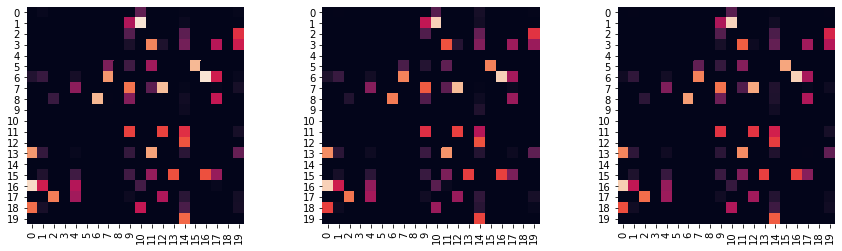

In [13]:
import seaborn as sns
def draw(data, x, y, ax):
    sns.heatmap(data, xticklabels=x, square=True, yticklabels=y, 
                vmin=0.1, vmax=1.0, cbar=False, ax=ax)
    
sent = list(range(n_nodes))
fig, axs = plt.subplots(1,3, figsize=(15, 4))
draw(torch.abs(graphs[0]), sent, sent, ax=axs[0])
draw(torch.abs(graphs[1]), sent, sent, ax=axs[1])
draw(torch.abs(graphs[2]), sent, sent, ax=axs[2])
plt.show()

In [14]:
_, test_loader = data.loader(500)
test_loader = iter(test_loader)

In [15]:
test_data = next(test_loader)[0]
xx, z, adj = model_log.log['models'][0](test_data.double())  
test_data[:1,:7,:]
xx[:1,:7,:]

tensor([[[  8.8154,   3.0704,  10.8089,  -7.2489,  12.6810],
         [-10.8212,  -6.3386,  -9.8525,   7.4516, -11.0496],
         [ 16.8772,   7.2761,  22.5990, -13.8480,  23.8033],
         [ -1.6533,  -2.8185,   1.2785,  -0.8786,   1.9609],
         [-30.9756, -16.6420, -34.2362,  17.9550, -36.7439],
         [ -1.1958,  -1.8012,   0.6759,  -3.1174,   1.5678],
         [  4.0180,   1.0536,   6.0217,  -5.9694,   7.1691]]])

tensor([[[ 12.5377,   5.3905,  16.3146, -10.6072,  18.5626],
         [-13.1670,  -7.7785, -12.8722,   6.3727, -13.2084],
         [ 20.0812,   9.2726,  24.7503, -15.5522,  27.7392],
         [ -0.5227,  -1.2998,   1.4569,  -1.9713,   2.4669],
         [-31.7708, -17.3818, -34.1056,  18.8103, -36.2379],
         [ -0.5020,  -1.2888,   1.4799,  -1.9845,   2.4918],
         [  0.1294,  -0.8883,   2.1984,  -2.4140,   3.2590]]],
       dtype=torch.float64, grad_fn=<SliceBackward>)

In [16]:
blah

NameError: name 'blah' is not defined

## SEM Evaluation

In [ ]:
g_learned = SpaceTime.adjacency(optimizerL.show_adj(0.2).numpy())
g_learned.draw_graph()

In [ ]:
data, _ = next(testdata)
preds, z_train, origin_A = autoencoder(data.double()) 

In [ ]:
autoencoder.eval()

data = next(iter(test_loader))[0].double()
preds, noise, _ = autoencoder(data.double()) 
pass;

In [ ]:
X_train = NodeData(g.data, bins=10)
XX_train = NodeData(preds.detach().numpy(), bins=10)
Z_learned = NodeData(noise.detach().numpy(), bins=10)
X_learned = NodeData(preds.detach().numpy(), bins=10)

pX_train = GraphSampler(g, X_train)
pXX_train = GraphSampler(g, XX_train)
pZ_learned = GraphSampler(g_learned, Z_learned)
pX_learned = GraphSampler(g_learned, X_learned)

In [ ]:
Z_resampled_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000), bins = Z_learned.edges())
Z_resampled_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000), bins = Z_learned.edges())

In [ ]:
pZ_resampled_cdf = GraphSampler(g_learned, Z_resampled_cdf)
pZ_resampled_pdf = GraphSampler(g_learned, Z_resampled_pdf)

In [ ]:
preds_resampled_cdf = autoencoder.decode(torch.Tensor(Z_resampled_cdf.data()).double())
preds_resampled_pdf = autoencoder.decode(torch.Tensor(Z_resampled_pdf.data()).double())
X_resampled_cdf = NodeData(preds_resampled_cdf.detach().numpy(), bins=X_train.edges())
X_resampled_pdf = NodeData(preds_resampled_pdf.detach().numpy(), bins=X_train.edges())

pX_resampled_cdf = GraphSampler(g_learned, X_resampled_cdf)
pX_resampled_pdf = GraphSampler(g_learned, X_resampled_pdf)

In [ ]:
fig, axs = plt.subplots(2, 4, sharex='col', sharey='col', figsize = (16,6))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_Z(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pZ_learned.get_contour_conditional(d,c), levels=50)
#     axs[1][col].set_title(r'$P_Z(%s|%s)$    (cdf resampled histo)'%(d,c))
#     axs[1][col].contour(*pZ_resampled_cdf.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[1][col].contour(*pZ_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

In [ ]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='col', figsize = (16,9))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (preds histo)'%(d,c))
    axs[1][col].contour(*pXX_train.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_pdf.get_contour_conditional(d,c), levels=50)
pass;

In [ ]:
# plt.plot(pX_train.node_data.axes(0)[0], pX_train.histogram.compute_joint(0)[1])
# plt.plot(pX_train.node_data.axes(1)[0], pX_train.histogram.compute_joint(1)[1])
# plt.show()
# plt.plot(pX_mutil.node_data.axes(0)[0], pX_mutil.histogram.compute_joint(0)[1])
# plt.plot(pX_mutil.node_data.axes(1)[0], pX_mutil.histogram.compute_joint(1)[1])
# pass;

In [ ]:
# truth = pX.histogram.compute_conditional(4,(2,))[1]
# generated = pX_new.histogram.compute_conditional(4,(2,))[1]
# _, truth_ = pX.histogram._epsilonize((), truth)
# _, generated_ = pX.histogram._epsilonize((), generated)
# np.sum(truth_*np.log((truth_/generated_)))/np.prod(truth.shape)

In [ ]:
# np.sum(truth)
# np.sum(truth_*np.log((truth_/generated_)), axis=0, keepdims=True)
# np.exp(np.sum(-truth_*np.log((truth_/(truth_*0.1)))))

In [ ]:
blah

## Graph Mutilation Tests

In [ ]:
sim_mutil = Simulator(g.mutilate(mutilate).numpy())
sim_mutil.sem(7500, 'nonlinear_2')
g_mutil = SpaceTime.simulation(sim_mutil)
g_mutil.adj
g_mutil.draw_graph()

In [ ]:
g_learned.draw_graph()

g_learned_mutil = SpaceTime.adjacency(g_learned.mutilate(mutilate).numpy())
g_learned_mutil.draw_graph()

In [ ]:
X_mutil = NodeData(g_mutil.data, bins=10)
pX_mutil = GraphSampler(g, X_mutil)

In [ ]:
Z_resampled_mutil_cdf = NodeData(pZ_learned.resample_from_cdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
Z_resampled_mutil_pdf = NodeData(pZ_learned.resample_from_pdf(size=10000, mutilate=[mutilate]), bins = Z_learned.edges())
pZ_resampled_mutil_cdf = GraphSampler(g_learned, Z_resampled_mutil_cdf)
pZ_resampled_mutil_pdf = GraphSampler(g_learned, Z_resampled_mutil_pdf)

In [ ]:
preds_resampled_mutil_cdf = autoencoder.decode(torch.Tensor(Z_resampled_mutil_cdf.data()).double(), 
                                       g_learned_mutil.adj, Wa_train)
preds_resampled_mutil_pdf = autoencoder.decode(torch.Tensor(Z_resampled_mutil_pdf.data()).double(), 
                                       g_learned_mutil.adj, Wa_train)
X_resampled_mutil_cdf = NodeData(preds_resampled_mutil_cdf.detach().numpy(), bins=X_learned.edges())
X_resampled_mutil_pdf = NodeData(preds_resampled_mutil_pdf.detach().numpy(), bins=X_learned.edges())
pX_resampled_mutil_cdf = GraphSampler(g_learned_mutil, X_resampled_mutil_cdf)
pX_resampled_mutil_pdf = GraphSampler(g_learned_mutil, X_resampled_mutil_pdf)

In [ ]:
fig, axs = plt.subplots(4, 4, sharex='col', sharey='col', figsize = (16,12))
for col, (d,c) in col_plot_dict.items():
    axs[0][col].set_title(r'$P_X(%s|%s)$    (true histo)'%(d,c))
    axs[0][col].contour(*pX_train.get_contour_conditional(d,c), levels=50)
    axs[1][col].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(d,c))
    axs[1][col].contour(*pX_mutil.get_contour_conditional(d,c), levels=50)
    axs[2][col].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(d,c))
    axs[2][col].contour(*pX_resampled_mutil_cdf.get_contour_conditional(d,c), levels=50)
    axs[3][col].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(d,c))
    axs[3][col].contour(*pX_resampled_mutil_pdf.get_contour_conditional(d,c), levels=50)
    
pass;

In [ ]:
fig, axs = plt.subplots(3, 3, sharex='col', sharey='col', figsize = (12,9))

axs[0][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[0][0].contour(*pZ_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_Z(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][0].contour(*pZ_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_Z(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][0].contour(*pZ_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)
pass;

In [ ]:
def Pi_UNj_DOk(i, j, k, histogram):
    do = np.zeros(histogram.compute_joint(i, k)[1].shape)
    latent = histogram.compute_joint(j)[1]
    
    for n in range(len(latent)):
        do += histogram.compute_conditional(i,(j,k))[1][:,n,:]*latent[n]
    return do

In [ ]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize = (12,9))
axs[0][0].set_title(r'$P_X(%s|%s)$    (true histo)'%(observe,mutilate))
axs[0][0].contour(*pX_train.get_contour_conditional(observe,mutilate), levels=50)
axs[1][0].set_title(r'$P_X(%s|%s)$    (cdf resampled histo)'%(observe,mutilate))
axs[1][0].contour(*pX_resampled_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][0].set_title(r'$P_X(%s|%s)$    (pdf resampled histo)'%(observe,mutilate))
axs[2][0].contour(*pX_resampled_pdf.get_contour_conditional(observe,mutilate), levels=50)

axs[0][1].set_title(r'$P_X(%s|%s)$    (true mutil histo)'%(observe,mutilate))
axs[0][1].contour(*pX_mutil.get_contour_conditional(observe,mutilate), levels=50)
axs[1][1].set_title(r'$P_X(%s|%s)$    (cdf resampled mutil histo)'%(observe,mutilate))
axs[1][1].contour(*pX_resampled_mutil_cdf.get_contour_conditional(observe,mutilate), levels=50)
axs[2][1].set_title(r'$P_X(%s|%s)$    (pdf resampled mutil histo)'%(observe,mutilate))
axs[2][1].contour(*pX_resampled_mutil_pdf.get_contour_conditional(observe,mutilate), levels=50)



axs[0][2].set_title(r'$P_X(%s|%s)$    (true adjusted histo)'%(observe,mutilate))
axs[0][2].contour(*np.meshgrid(*pX_train.node_data.axes(observe,mutilate)), 
                  Pi_UNj_DOk(observe,latent,mutilate, pX_train.histogram).T, levels=50)
pass;